In [1]:
import numpy as np
import pandas as pd
import sqlalchemy as sa

In [2]:
from dask import dataframe as dd 
from dask import array as da
from dask.diagnostics import ProgressBar # type: ignore

In [3]:
# read h5
embeddings = dd.read_hdf('embeddings.h5', key='embeddings', mode='r', chunksize=1000)

# load 10'000
# embeddings = embeddings.head(10000)

In [4]:
embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.202381,0.087937,0.221610,0.171785,-0.782774,-0.325774,0.120273,0.625501,-0.072252,0.004225,...,0.421689,-0.342691,0.289151,-0.748062,-0.896266,0.605513,0.282313,0.264579,0.758309,0.718300
1,-0.202381,0.087936,0.221610,0.171785,-0.782773,-0.325774,0.120273,0.625501,-0.072252,0.004225,...,0.421690,-0.342690,0.289151,-0.748062,-0.896267,0.605513,0.282313,0.264579,0.758308,0.718299
2,-0.202380,0.087936,0.221610,0.171785,-0.782774,-0.325774,0.120273,0.625501,-0.072252,0.004225,...,0.421690,-0.342690,0.289151,-0.748062,-0.896267,0.605513,0.282313,0.264579,0.758308,0.718299
3,-0.202380,0.087936,0.221610,0.171785,-0.782773,-0.325774,0.120273,0.625501,-0.072252,0.004225,...,0.421690,-0.342690,0.289151,-0.748062,-0.896266,0.605513,0.282313,0.264579,0.758308,0.718299
4,-0.202380,0.087936,0.221611,0.171787,-0.782776,-0.325774,0.120273,0.625500,-0.072251,0.004225,...,0.421690,-0.342691,0.289150,-0.748062,-0.896269,0.605514,0.282313,0.264579,0.758308,0.718300


In [5]:
embeddings

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
npartitions=552,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,floa

In [6]:
embeddings.shape

(<dask_expr.expr.Scalar: expr=FromGraph(4429402).size() // 768, dtype=int64>,
 768)

In [45]:
from torch import nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torch
device = torch.device("cuda")

In [46]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(768, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 768)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z

In [47]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [10]:
from torch.utils.data import DataLoader, TensorDataset

# Convert Dask DataFrame to NumPy array
embeddings_np = embeddings.compute().values

# Convert NumPy array to PyTorch tensor
embeddings_tensor = torch.tensor(embeddings_np, dtype=torch.float32, device=device)

# Create a TensorDataset
dataset = TensorDataset(embeddings_tensor)

In [48]:
import tqdm

x_dim = int(embeddings.shape[1])
latent_dim = 2
hidden_dim = 50

model = VariationalAutoencoder(2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

batch_size = 10_000

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

total_batches = len(dataloader)

model.train()

for epoch in range(30):
    overall_loss = 0

    batches = tqdm.tqdm(enumerate(dataloader), total=total_batches)
    batches.set_description(f"Epoch {epoch + 1}")
    for batch_idx, (x,) in batches:
        x = x.to(device)
        optimizer.zero_grad()

        x_hat = model(x)
        loss =  ((x - x_hat)**2).sum() + model.encoder.kl 
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()

        batches.set_postfix(loss=overall_loss / (batch_idx + 1))

    if epoch == 9:
        optimizer.param_groups[0]['lr'] = 1e-4

    if epoch == 19:
        optimizer.param_groups[0]['lr'] = 1e-5
        
    print("Epoch", epoch + 1, "Average Loss: ", overall_loss / batch_idx)

Epoch 1: 100%|██████████| 56/56 [00:04<00:00, 11.35it/s, loss=7.12e+6]


Epoch 1 Average Loss:  7253688.370454545


Epoch 2: 100%|██████████| 56/56 [00:04<00:00, 11.37it/s, loss=6.84e+6]


Epoch 2 Average Loss:  6967025.972727273


Epoch 3: 100%|██████████| 56/56 [00:04<00:00, 11.96it/s, loss=6.82e+6]


Epoch 3 Average Loss:  6946047.525


Epoch 4: 100%|██████████| 56/56 [00:04<00:00, 11.49it/s, loss=6.81e+6]


Epoch 4 Average Loss:  6933652.747727273


Epoch 5: 100%|██████████| 56/56 [00:04<00:00, 11.22it/s, loss=6.8e+6] 


Epoch 5 Average Loss:  6925494.036363636


Epoch 6: 100%|██████████| 56/56 [00:04<00:00, 11.35it/s, loss=6.8e+6]


Epoch 6 Average Loss:  6919596.027272727


Epoch 7: 100%|██████████| 56/56 [00:04<00:00, 12.06it/s, loss=6.79e+6]


Epoch 7 Average Loss:  6915178.475


Epoch 8: 100%|██████████| 56/56 [00:04<00:00, 11.39it/s, loss=6.79e+6]


Epoch 8 Average Loss:  6911605.322727272


Epoch 9: 100%|██████████| 56/56 [00:04<00:00, 11.40it/s, loss=6.79e+6]


Epoch 9 Average Loss:  6908450.829545454


Epoch 10: 100%|██████████| 56/56 [00:04<00:00, 11.46it/s, loss=6.78e+6]


Epoch 10 Average Loss:  6905379.25


Epoch 11: 100%|██████████| 56/56 [00:04<00:00, 11.45it/s, loss=6.78e+6]


Epoch 11 Average Loss:  6903967.247727273


Epoch 12: 100%|██████████| 56/56 [00:04<00:00, 11.41it/s, loss=6.78e+6]


Epoch 12 Average Loss:  6903800.475


Epoch 13: 100%|██████████| 56/56 [00:04<00:00, 11.49it/s, loss=6.78e+6]


Epoch 13 Average Loss:  6903646.281818182


Epoch 14: 100%|██████████| 56/56 [00:04<00:00, 11.39it/s, loss=6.78e+6]


Epoch 14 Average Loss:  6903504.554545455


Epoch 15: 100%|██████████| 56/56 [00:04<00:00, 12.06it/s, loss=6.78e+6]


Epoch 15 Average Loss:  6903382.293181818


Epoch 16: 100%|██████████| 56/56 [00:04<00:00, 11.87it/s, loss=6.78e+6]


Epoch 16 Average Loss:  6903262.761363637


Epoch 17: 100%|██████████| 56/56 [00:04<00:00, 11.35it/s, loss=6.78e+6]


Epoch 17 Average Loss:  6903160.529545454


Epoch 18: 100%|██████████| 56/56 [00:05<00:00, 11.05it/s, loss=6.78e+6]


Epoch 18 Average Loss:  6903067.113636363


Epoch 19: 100%|██████████| 56/56 [00:04<00:00, 11.77it/s, loss=6.78e+6]


Epoch 19 Average Loss:  6902981.297727273


Epoch 20: 100%|██████████| 56/56 [00:04<00:00, 11.29it/s, loss=6.78e+6]


Epoch 20 Average Loss:  6902906.481818181


Epoch 21: 100%|██████████| 56/56 [00:05<00:00, 10.86it/s, loss=6.78e+6]


Epoch 21 Average Loss:  6902866.715909091


Epoch 22: 100%|██████████| 56/56 [00:05<00:00, 11.16it/s, loss=6.78e+6]


Epoch 22 Average Loss:  6902860.981818181


Epoch 23: 100%|██████████| 56/56 [00:04<00:00, 11.23it/s, loss=6.78e+6]


Epoch 23 Average Loss:  6902851.872727273


Epoch 24: 100%|██████████| 56/56 [00:05<00:00, 10.72it/s, loss=6.78e+6]


Epoch 24 Average Loss:  6902846.015909091


Epoch 25: 100%|██████████| 56/56 [00:05<00:00, 10.76it/s, loss=6.78e+6]


Epoch 25 Average Loss:  6902838.95


Epoch 26: 100%|██████████| 56/56 [00:04<00:00, 11.45it/s, loss=6.78e+6]


Epoch 26 Average Loss:  6902830.075


Epoch 27: 100%|██████████| 56/56 [00:05<00:00, 11.10it/s, loss=6.78e+6]


Epoch 27 Average Loss:  6902822.081818182


Epoch 28: 100%|██████████| 56/56 [00:05<00:00, 10.48it/s, loss=6.78e+6]


Epoch 28 Average Loss:  6902813.245454545


Epoch 29: 100%|██████████| 56/56 [00:04<00:00, 11.33it/s, loss=6.78e+6]


Epoch 29 Average Loss:  6902807.861363636


Epoch 30: 100%|██████████| 56/56 [00:05<00:00, 10.71it/s, loss=6.78e+6]

Epoch 30 Average Loss:  6902798.19090909


In [50]:
# Transform all embeddings into the latent space
with torch.no_grad():
    embeddings_latent = model.encoder(embeddings_tensor)

# Convert to numpy array if needed
embeddings_latent_np = embeddings_latent.cpu().numpy()

# Print the shape of the new latent embeddings
print(embeddings_latent_np.shape)

(551657, 2)


In [52]:
embeddings_latent_np[:10]

array([[-1.124333  ,  0.8721064 ],
       [-1.8931993 ,  0.04567691],
       [-0.40220502, -0.11090052],
       [-0.18179856,  0.8229193 ],
       [-0.1052435 , -0.6296817 ],
       [ 0.29353514,  1.1136594 ],
       [-1.8626511 ,  2.50162   ],
       [ 0.6198773 , -2.171268  ],
       [-0.04316505,  1.0352634 ],
       [ 1.0550921 ,  0.01768531]], dtype=float32)

In [53]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=150,
    init='random',
    n_init=5,
    verbose=1,
)

kmeans.fit(embeddings_latent_np)

Initialization complete
Iteration 0, inertia 19705.537109375.
Iteration 1, inertia 12803.908203125.
Iteration 2, inertia 11045.4677734375.
Iteration 3, inertia 10202.46875.
Iteration 4, inertia 9711.306640625.
Iteration 5, inertia 9378.4521484375.
Iteration 6, inertia 9134.5625.
Iteration 7, inertia 8941.7490234375.
Iteration 8, inertia 8785.2724609375.
Iteration 9, inertia 8651.99609375.
Iteration 10, inertia 8536.36328125.
Iteration 11, inertia 8431.7001953125.
Iteration 12, inertia 8338.5908203125.
Iteration 13, inertia 8257.572265625.
Iteration 14, inertia 8184.92578125.
Iteration 15, inertia 8119.02392578125.
Iteration 16, inertia 8060.62109375.
Iteration 17, inertia 8009.005859375.
Iteration 18, inertia 7962.51220703125.
Iteration 19, inertia 7920.734375.
Iteration 20, inertia 7882.1689453125.
Iteration 21, inertia 7847.9658203125.
Iteration 22, inertia 7817.72021484375.
Iteration 23, inertia 7789.67822265625.
Iteration 24, inertia 7764.23486328125.
Iteration 25, inertia 7741.059

KMeans(init='random', n_clusters=150, n_init=5, verbose=1)

In [54]:
# save embedded space
latent_space_df = pd.DataFrame(embeddings_latent_np)
latent_space_df.to_hdf('latent_space.h5', key='latent_space', mode='w')

In [55]:
cluster_labels = kmeans.labels_
cluster_labels

array([ 87, 102,  48, ..., 115,  61, 115], dtype=int32)

In [56]:
# debug clustering results
kmeans.cluster_centers_.shape

(150, 2)

In [57]:
kmeans.cluster_centers_[0]

array([ 0.24635121, -0.29946953], dtype=float32)

In [ ]:
from sklearn.manifold import Isomap, LocallyLinearEmbedding
from sklearn.decomposition import IncrementalPCA

# isomap = Isomap(n_components=2, n_neighbors=15, p=2)
# lle = LocallyLinearEmbedding(n_components=2, n_neighbors=15)
pca = IncrementalPCA(n_components=2)

transformed_embeddings = pca.fit_transform(embeddings_latent_np)

In [59]:
transformed_embeddings.shape

(551657, 2)

In [60]:
# error of the embedding
pca.explained_variance_ratio_

array([0.51032358, 0.48967642])

In [61]:
embeddings_latent_np.shape

(551657, 2)

In [62]:
transformed_embeddings.shape

(551657, 2)

In [63]:
embeddings_latent_np[:10]

array([[-1.124333  ,  0.8721064 ],
       [-1.8931993 ,  0.04567691],
       [-0.40220502, -0.11090052],
       [-0.18179856,  0.8229193 ],
       [-0.1052435 , -0.6296817 ],
       [ 0.29353514,  1.1136594 ],
       [-1.8626511 ,  2.50162   ],
       [ 0.6198773 , -2.171268  ],
       [-0.04316505,  1.0352634 ],
       [ 1.0550921 ,  0.01768531]], dtype=float32)

In [65]:
# save
transformed_embeddings = pd.DataFrame(embeddings_latent_np)
transformed_embeddings.to_hdf('tsne_embeddings_3.h5', key='tsne_embeddings', mode='w', format='table')

In [66]:
transformed_embeddings

,0,1
0,-1.124333,0.872106
1,-1.893199,0.045677
2,-0.402205,-0.110901
3,-0.181799,0.822919
4,-0.105243,-0.629682
...,...,...
551652,0.152619,0.779043
551653,0.446421,0.343825
551654,-0.592172,0.062317
551655,0.837413,-0.508271


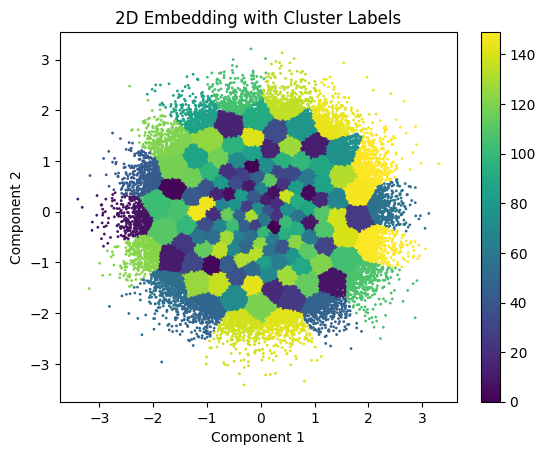

In [68]:
# plot
import matplotlib.pyplot as plt


plt.scatter(transformed_embeddings[0], transformed_embeddings[1], c=cluster_labels, cmap='viridis', s=1)
plt.colorbar()
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('2D Embedding with Cluster Labels')
plt.show()

In [69]:
# save to h5
tsne_embeddings = pd.DataFrame(transformed_embeddings)
tsne_embeddings.to_hdf('tsne_embeddings_3.h5', key='tsne_embeddings', mode='w', format='table')

In [70]:
cluster_labels = pd.DataFrame(cluster_labels)
cluster_labels.to_hdf('clusters_3.h5', key='clusters', mode='w', format='table')